In [262]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import json
from typing import Dict
from tqdm import tqdm
import sys

In [263]:
INPUT_FILE = '../data_100000.json'
# INPUT_FILE = '../data.json'


# with open(INPUT_FILE, 'r') as f:
#     for line in f:
#         line = line.strip()
#         r = json.loads(line)
#         print(r['login'])


In [264]:
def get_create_date_from_repo(repo) -> (int, int, int):
    d = map(int, repo['created_at'].split(' ')[0].split('-'))
    d = list(d)
    return (d[0], d[1], d[2])


In [265]:
repos = []
num_users = 0

with tqdm(total=10000, file=sys.stdout) as pbar:
    with open(INPUT_FILE, 'r') as f:
        for line in f:
            pbar.update(1)
            line = line.strip()
            r = json.loads(line)
            user_id = r['id']
            # filter out suspicious user accounts
            if r['is_suspicious']: continue

            num_users += 1
            if r['repo_list'] is None: continue
            for repo in r['repo_list']:
                # filter out non-owner repos
                if user_id != repo['owner_id']: continue
                # filter out repos created after 2018
                y = get_create_date_from_repo(repo)[0]
                # if y >= 2018: continue;
                repos.append(repo)

print('analyzing {} users'.format(num_users))
print('num repos:', len(repos))

100000it [00:05, 19080.34it/s]                         
analyzing 78608 users
num repos: 191567


In [266]:

print('an example repo:', repos[1])
# print(repos[0]['created_at'])
print(get_create_date_from_repo(repos[0]))

an example repo: {'fork': False, 'license': None, 'has_wiki': True, 'description': None, 'language': None, 'default_branch': 'master', 'created_at': '2017-07-25 13:51:12', 'forks_count': 0, 'updated_at': '2017-07-25 13:51:12', 'pushed_at': '2017-07-25 13:56:08', 'full_name': 'MelLobo/Fonte', 'open_issues': 0, 'stargazers_count': 0, 'owner_id': 30438508, 'id': 98311519, 'size': 612}
(2017, 8, 23)


In [267]:
# test if the function works
# for repo in repos:
#     print(repo['full_name'], repo['language'], get_create_date_from_repo(repo))

In [268]:
def rank_by_values(d: Dict[str, str]) -> [(str, int)]:
    kvs = list(d.items())
    kvs.sort(key=lambda x: x[1], reverse=True)
    return kvs

all_langs = {}
for repo in repos:
    lang = repo['language']
    all_langs[lang] = all_langs.get(lang, 0) + 1

print('total number of different languages', len(all_langs) - 1)
all_langs = rank_by_values(all_langs)
top_langs = all_langs[10:30]
for l in top_langs:
    print(l)

total number of different languages 221
('C', 5465)
('Objective-C', 3489)
('Shell', 3294)
('Go', 2141)
('Jupyter Notebook', 1852)
('Swift', 1755)
('TypeScript', 1678)
('R', 1624)
('Scala', 823)
('Lua', 611)
('Vue', 490)
('TeX', 488)
('Matlab', 483)
('CoffeeScript', 463)
('PowerShell', 407)
('Makefile', 403)
('Perl', 399)
('Arduino', 359)
('Groovy', 357)
('Kotlin', 319)


In [269]:
from matplotlib import rcParams
# rcParams['font.family'] = 'Times New Roman'
# rcParams['font.family'] = ''

def unzip(d: Dict[int, int]) -> ([int], [int]):
    kvs = list(d.items())
    kvs.sort(key=lambda x: x[0])
    a, b = list(map(list, zip(*kvs)))
    return a, b

common_settings = {
    'linestyle': '--',
    # 'linewidth': 2,
    'marker': 'o',
}

# common_settings = { 'linestyle': '-', 'linewidth': 3, 'marker': '' }
# [(language, [(year, count)])]
def draw_languages(data: Dict[str, Dict[int, int]], no_debug=False):
    global all_langs
    top_langs = all_langs[1:11]
    print(top_langs)

    top_set = set(map(lambda x: x[0], filter(lambda x: x[0] is not None, top_langs)))
    print(top_set)
    
    total = {}
    for (lang, d) in data.items():
        # if lang not in top_set: continue
        xs, ys = unzip(d)
        for x, y in zip(xs, ys):
            total[x] = total.get(x, 0) + y

    #for (lang, d) in data.items():
    for (lang, c) in top_langs:
        d = data[lang]
        if lang not in top_set: continue
        xs, ys = unzip(d)
        ys = [y / total[x] for x, y in zip(xs, ys)]
        print(lang)
        plt.plot(xs, ys, label=lang)

#     plt.axvline(x=1.0, lw=4.0, color='black')
#     # plt.plot(nethint0, ys, linestyle='--', marker='o', label="No Information", color = 'blue')
#     # plt.errorbar(nethint0, ys, yerr=nethint0_std[8], linewidth = 0, elinewidth = 2, ecolor='blue')
#     plt.plot(plink, ys, linestyle='--', marker='o', label="User Probe", color = 'orange')
#     # plt.errorbar(nethint1, ys, yerr=nethint1_std[8], linewidth = 0, elinewidth = 2, ecolor='orange')
#     plt.plot(nethint1, ys, linestyle='--', marker='o', label="NetHint Level 1", color = 'green')
#     plt.plot(nethint2, ys, linestyle='--', marker='o', label="NetHint Level 2", color = 'red')
#     # plt.plot(nethint2_adaptive, ys, linestyle='--', marker='o', label="Level 2 AutoTune", color = 'blue')

    plt.grid()
    plt.xlabel("Seasons", fontsize = 14)
    # plt.xticks(nethint0, fontsize = 20)
    plt.ylabel("% of Repositories Created Per Season", fontsize = 12)
    #plt.ylim([0, 1])
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    # plt.xticks(np.arange(minx, maxx, (maxx - minx) / max_ticks), fontsize = 18)
    plt.legend(fontsize = 12, ncol=2,handleheight=2)

    name = "/tmp/popular_lang_10.pdf"
    plt.savefig(name, bbox_inches='tight')
    plt.show()

[('JavaScript', 29129), ('Java', 23258), ('Python', 15006), ('HTML', 11901), ('PHP', 8012), ('Ruby', 7885), ('C#', 7195), ('C++', 7019), ('CSS', 6121), ('C', 5465)]
{'Java', 'C#', 'Python', 'CSS', 'PHP', 'C++', 'JavaScript', 'HTML', 'C', 'Ruby'}
JavaScript
Java
Python
HTML
PHP
Ruby
C#
C++
CSS
C


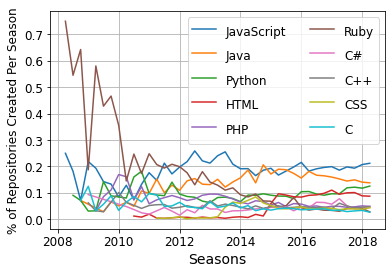

In [270]:
bucket = {}
for repo in repos:
    lang = repo['language']
    if lang is None: continue
    (y, m, d) = get_create_date_from_repo(repo)
    # pos = y * 12 + m - 1
    pos = y + (m - 1) // 3 * 3 / 12
    if lang not in bucket:
        bucket[lang] = {}
    bucket[lang][pos] = bucket[lang].get(pos, 0) + 1
# print(bucket)

draw_languages(bucket)